SD: Do a LS- Periodogram for sk2003 dataset.

In [1]:
from astropy.timeseries import LombScargle
from astropy import time
from astropy.coordinates import get_sun, EarthLocation, AltAz, solar_system_ephemeris
from astropy import units as un
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
data = pd.read_csv('./data/sk2003paper.dat', sep='\s+', index_col=0)
data

,year,t_mean(m),t_mean(d),t_mean(hm),t_start(m),t_start(d),t_start(hm),t_end(m),t_end(d),t_end(hm),r2,flux,flux_err_up,flux_err_down
#,,,,,,,,,,,,,,
1,1996,6,2,03:46,5,31,04:31,6,5,08:49,1.029,2.74,0.63,0.53
2,1996,6,7,14:58,6,5,14:13,6,10,01:19,1.030,2.83,0.75,0.62
3,1996,6,12,12:40,6,10,01:27,6,15,04:36,1.031,2.30,0.53,0.45
4,1996,6,17,16:37,6,15,09:14,6,20,03:41,1.032,1.79,0.55,0.44
5,1996,6,22,03:07,6,20,03:45,6,25,04:55,1.033,3.15,0.74,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,2001,6,18,02:54,6,15,14:07,6,20,16:35,1.032,2.77,0.43,0.38
355,2001,6,23,13:36,6,20,16:38,6,26,16:58,1.033,1.60,0.38,0.33
356,2001,6,28,18:33,6,26,17:01,6,30,20:07,1.033,1.21,0.43,0.36


In [2]:
#convert yyyy/mm/dd hh:mm to jd

def convert_to_s(date: str):
    end_date = datetime.strptime(date, "%Y/%m/%d %H:%M")
    start = datetime(1970, 1, 1, 0, 0)
    return (end_date - start).total_seconds()

In [3]:
data['year'][1]

1996

In [4]:
times = np.array([convert_to_s(str(data['year'][i]) + '/' + str(data['t_mean(m)'][i]) + '/' + str(data['t_mean(d)'][i]) + ' ' + data['t_mean(hm)'][i]) for i in range(1,len(data)+1)]) * un.s

t_mean_days = [str(data['year'][i]) + '-' + str(data['t_mean(m)'][i]) + '-' + str(data['t_mean(d)'][i]) for i in range(1,len(data)+1)]

flux = data['flux'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_up = data['flux_err_up'].values * un.cm**-2 * un.s**-1 * 1e6
flux_err_down = data['flux_err_down'].values * un.cm**-2 * un.s**-1 * 1e6
avg_dists_2 = data['r2'].values * un.au

In [5]:
lsp = LombScargle(times, flux, dy=0.5*(flux_err_up+flux_err_down), normalization='log')
freq, power = lsp.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

lsp_d2 = LombScargle(times, np.multiply(flux, avg_dists_2), dy=np.multiply(0.5*(flux_err_up+flux_err_down), avg_dists_2), normalization='log')
freq_d2, power_d2 = lsp_d2.autopower(minimum_frequency=1e-8/un.year, maximum_frequency=20/un.year)

In [6]:
freq_max = freq[np.nanargmax(power)]
power_max = power[np.nanargmax(power)]

freq_d2_max = freq_d2[np.nanargmax(power_d2)]
power_d2_max = power_d2[np.nanargmax(power_d2)]

In [7]:
print(freq_max, power_max)
print(freq_d2_max, power_d2_max)

9.431971561475892 1 / yr 0.05564984203778157
9.431971561475892 1 / yr 0.058208952943571673


In [8]:
print(lsp.false_alarm_probability(power_max, method='bootstrap'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='bootstrap'))

0.18600000000000005
0.132


In [9]:
print(lsp.false_alarm_probability(power_max, method='naive'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='naive'))

0.04487045726623859
0.028727523780562394


In [10]:
print(lsp.false_alarm_probability(power_max, method='baluev'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='baluev'))

0.13669388941374463
0.09098339614543133


In [11]:
print(lsp.false_alarm_probability(power_max, method='davies'))
print(lsp_d2.false_alarm_probability(power_d2_max, method='davies'))

0.1469859442774657
0.09539191837440299


In [12]:
print('freq', np.round(freq_max, 2), np.round(freq_d2_max, 2))
print('power', np.round(power_max, 2), np.round(power_d2_max, 2))
print('btsrp', np.round(lsp.false_alarm_probability(power_max, method='bootstrap'), 2), np.round(lsp_d2.false_alarm_probability(power_d2_max, method='bootstrap'), 2))
print('naive', np.round(lsp.false_alarm_probability(power_max, method='naive'), 2), np.round(lsp_d2.false_alarm_probability(power_d2_max, method='naive'), 2))
print('baluev', np.round(lsp.false_alarm_probability(power_max, method='baluev'), 2), np.round(lsp_d2.false_alarm_probability(power_d2_max, method='baluev'), 2))
print('davies', np.round(lsp.false_alarm_probability(power_max, method='davies'), 2), np.round(lsp_d2.false_alarm_probability(power_d2_max, method='davies'), 2))

freq 9.43 1 / yr 9.43 1 / yr
power 0.06 0.06
btsrp 0.17 0.14
naive 0.04 0.03
baluev 0.14 0.09
davies 0.15 0.1


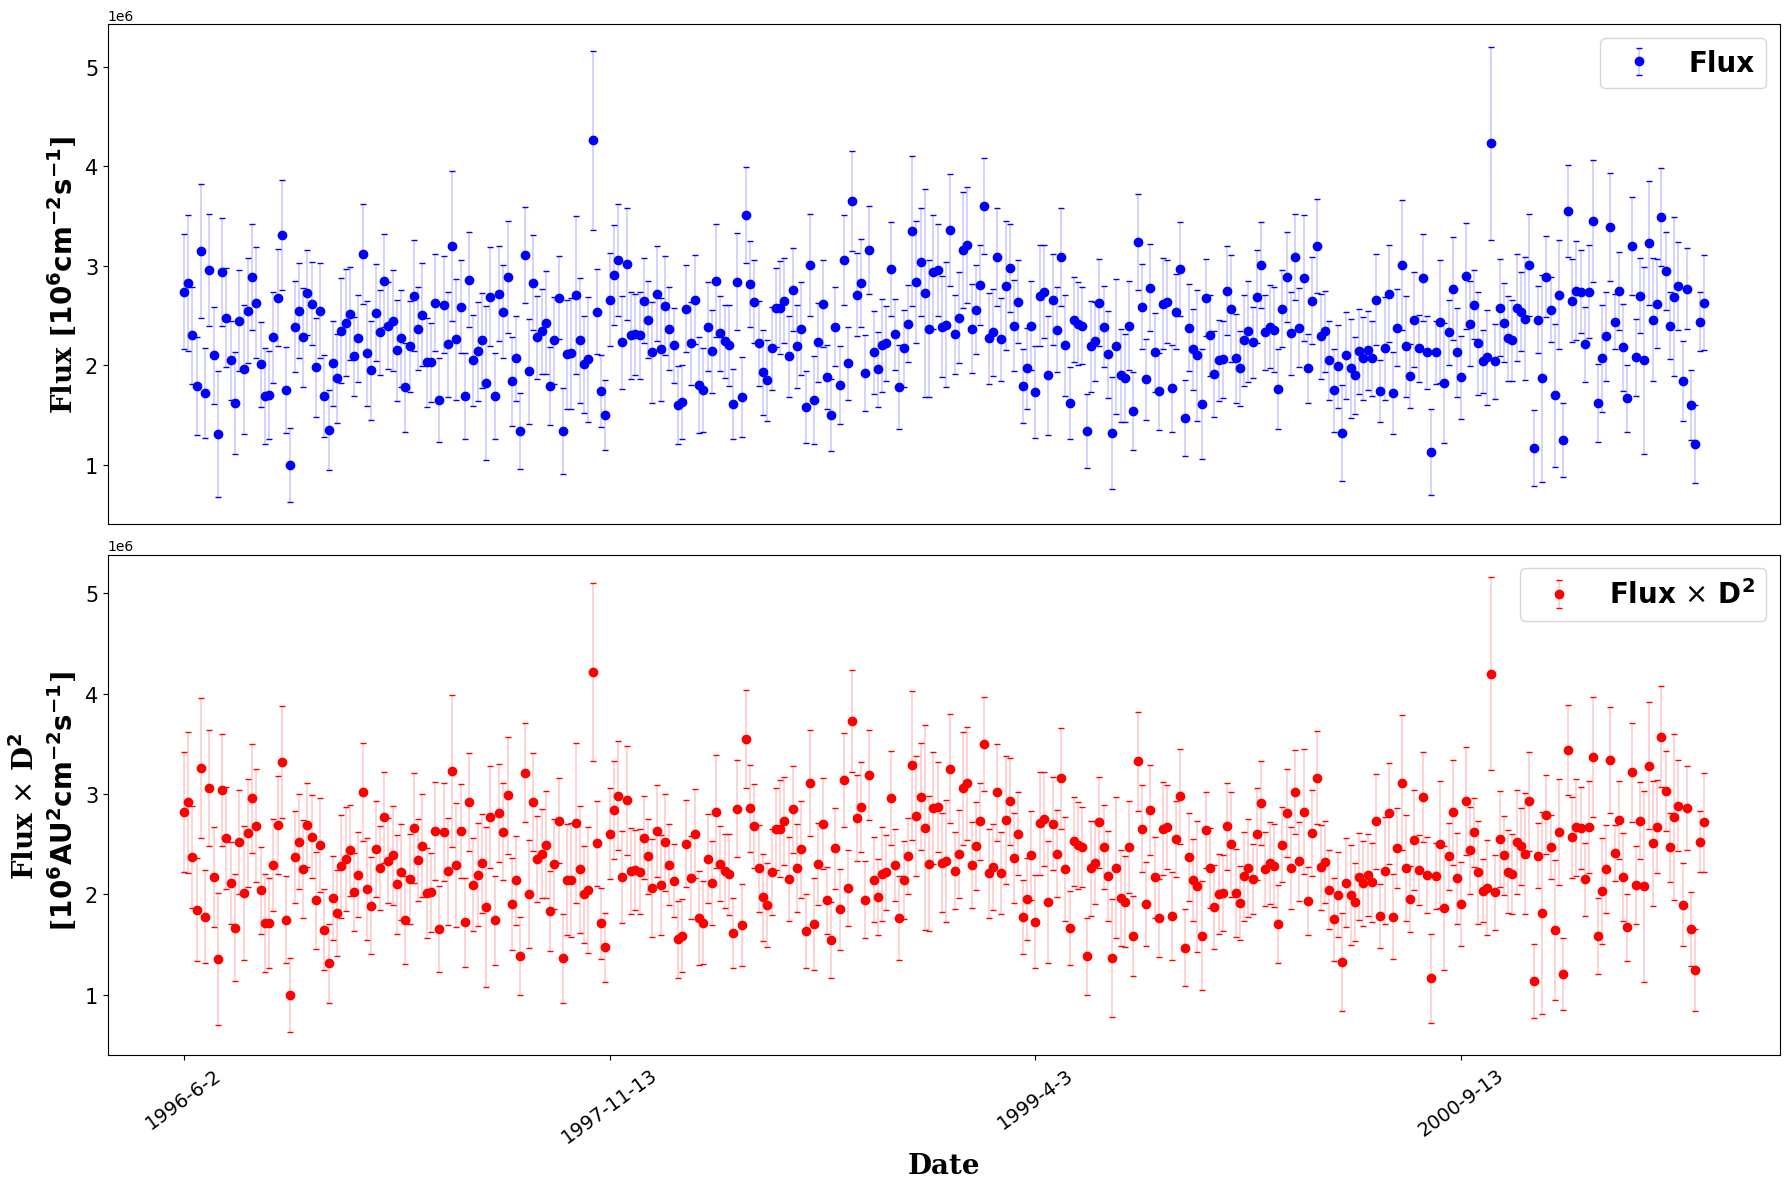

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(18, 12))

font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 20,
        }

ax[0].errorbar(t_mean_days, flux, yerr=0.5*(flux_err_up+flux_err_down), fmt='o', c='b', elinewidth=0.24, capsize=2, label='Flux')
ax[1].errorbar(t_mean_days, np.multiply(flux, avg_dists_2), yerr=np.multiply(0.5*(flux_err_up+flux_err_down), avg_dists_2), fmt='o', c='r', elinewidth=0.24, capsize=2, label='Flux $\\times$ D$\mathbf{^2}$')

ax[0].set_ylabel('Flux [$\mathbf{10^6 cm^{-2} s^{-1}}$]', fontdict=axesfont)


ax[1].set_ylabel('Flux $\\times$ D$\mathbf{^2}$\n [$\mathbf{10^6 AU^{2} cm^{-2} s^{-1}}$]', fontdict=axesfont)

for i in range(2):
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':20, 'weight':'bold'})
    
ax[0].set_xticks([])
ax[1].set_xlabel('Date',  fontdict=axesfont)
ax[1].set_xticks(t_mean_days[::100])
ax[1].xaxis.set_tick_params(labelsize=14, rotation=36)
plt.tight_layout()
plt.savefig('./outputs/timeseries_Super-K-original-data.pdf')
plt.show()

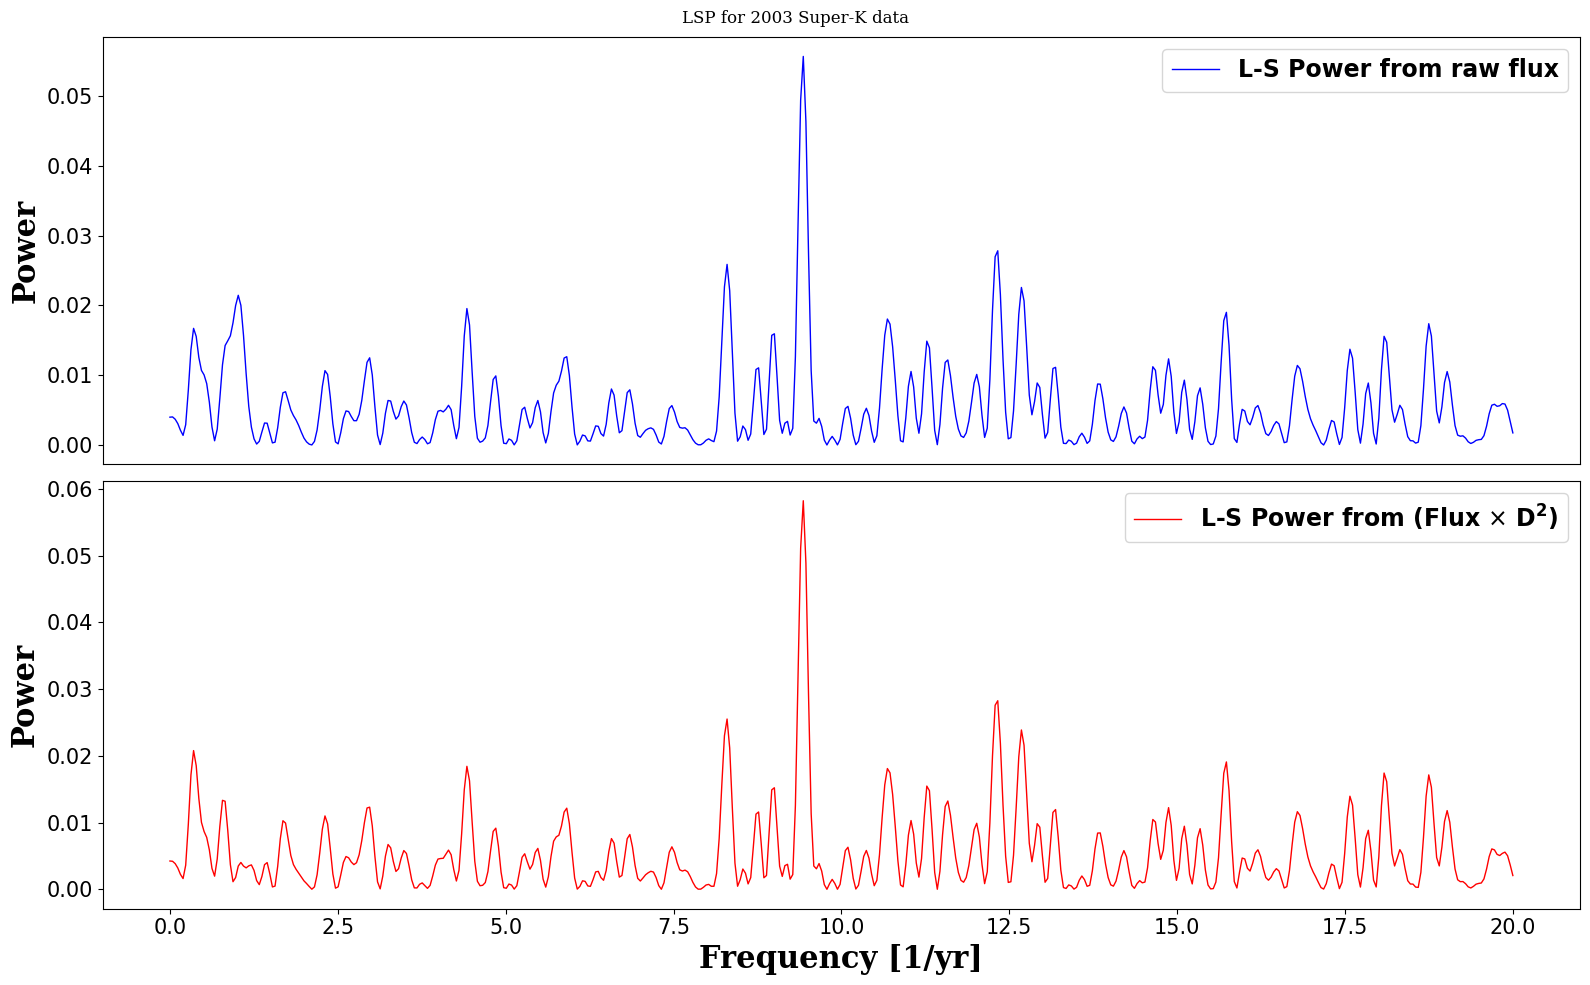

In [14]:
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 17,
        }
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

ax[0].plot(freq, power, '-', lw=1, c='b', label='L-S Power from raw flux')


# ax[0].set_title('Raw Power')
ax[1].plot(freq_d2, power_d2, '-', lw=1, c='r', label='L-S Power from (Flux $\\times$ D$\mathbf{^2}$)')
# ax[1].set_title('Power from Flux $\\times$ D^2')
for i in range(2):
    
    ax[i].set_ylabel('Power', fontdict=font)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].legend(prop={'size':17, 'weight':'bold'})

ax[0].set_xticks([])
ax[1].set_xlabel('Frequency [1/yr]', fontdict=font)
ax[1].xaxis.set_tick_params(labelsize=15)
plt.suptitle('LSP for 2003 Super-K data', fontdict=font)
plt.tight_layout()
plt.savefig('./outputs/ls_power_Super-K-original-data.pdf', format='pdf')
plt.show()